In [1]:
import SiemensQuadraProperties as sqp
import ExplorerProperties as ep
from ActivityTools import *
from SimulationDataset import *

import matplotlib.pyplot as mpl
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "upper left",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

#Fix random seed for reproducibility, or skip this to allow the results to vary
import random
random.seed( 1234 )

Calculate NECR versus time as an F18 linear source decays from an initial 1100MBq activity (plotted activity is divided by the cylindrical phantom volume in cc).

Statistical fluctuation of the result can be reduced by increasing the simulationWindow parameter, at the cost of CPU time. The size of the simulated dataset can also be increased, but this has a lesser effect for counting experiments.

The CreateDataset command will run the Geant4 simulation with the appropriate parameters for source and detector type and length. The requested number of events will be simulated, but only those within the specified energy window will be loaded for analysis. If a suitable dataset already exists it will be re-used without further simulation.

In [2]:
def NECRatTimeF18( tracerData, crystalData, crystalActivity, detectorRadius,
                  phantomLength, simulationWindow=1E-2, coincidenceWindow=4.7E-9,
                  EnergyResolution=0.0, TimeResolution=0.0 ):

    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2
    
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    truesAtTime = []
    rPlusSAtTime = []
    scattersAtTime = []
    randomsAtTime = []
    necrStatAtTime = []
    truesStatAtTime = []
    rPlusSStatAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 1100E6, timeSec )

        necr, trues, rPlusS, Scatters, Randoms = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData],
                                                   simulationWindow, coincidenceWindow, detectorRadius,
                                                   ZMin=-zWindow, ZMax=zWindow, UsePhotonTime=True,
                                                   EnergyResolution=EnergyResolution, TimeResolution=TimeResolution )
        necrAtTime.append( necr )
        truesAtTime.append( trues )
        rPlusSAtTime.append( rPlusS )
        scattersAtTime.append( Scatters )
        randomsAtTime.append( Randoms )
        activityAtTime.append( activity / phantomVolume )

    return activityAtTime, necrAtTime, truesAtTime, rPlusSAtTime, scattersAtTime, randomsAtTime

# Simulation parameters
phantomLength = 700
datasetSize = 1000000
siemensEmin = 435.0
siemensEmax = 585.0
explorerEmin = 430.0
explorerEmax = 645.0

# Nominal
detectorMaterial = "LSO"
tracerDataSiemens = CreateDataset( 1024, "Siemens", phantomLength, "LinearF18", datasetSize, siemensEmin, siemensEmax, detectorMaterial )
crystalDataSiemens = CreateDataset( 1024, "Siemens", phantomLength, "Siemens", datasetSize, siemensEmin, siemensEmax, detectorMaterial )
activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens, scatterAtTimeSiemens, randomAtTimeSiemens = NECRatTimeF18(
    tracerDataSiemens, crystalDataSiemens, sqp.Lu176decaysInMass( sqp.DetectorMass( detectorMaterial ) ), sqp.DetectorRadius(),
    phantomLength )
mpl.clf()

detectorMaterial = "LYSO"
tracerDataExplorer = CreateDataset( 1850, "Explorer", phantomLength, "LinearF18", datasetSize, explorerEmin, explorerEmax, detectorMaterial )
crystalDataExplorer = CreateDataset( 1850, "Explorer", phantomLength, "Explorer", datasetSize, explorerEmin, explorerEmax, detectorMaterial )
activityAtTimeExplorer, necrAtTimeExplorer, trueAtTimeExplorer, rPlusSAtTimeExplorer, scatterAtTimeExplorer, randomAtTimeExplorer = NECRatTimeF18(
    tracerDataExplorer, crystalDataExplorer, ep.Lu176decaysInMass( ep.DetectorMass( detectorMaterial ) ), ep.DetectorRadius(),
    phantomLength )
mpl.clf()

Re-using previous simulation
347784.0 events loaded (1000000 simulated) with average 1.1460331700135717 hits/event
Re-using previous simulation
108334.0 events loaded (1000000 simulated) with average 1.0074030313659608 hits/event
Re-using previous simulation
395186.0 events loaded (1000000 simulated) with average 1.1569235752278675 hits/event
Re-using previous simulation
234609.0 events loaded (1000000 simulated) with average 1.000635099250242 hits/event


<Figure size 640x480 with 0 Axes>

Compare the results for both Siemens Quadra and EXPLORER detectors at their default aFOV values, for a 700mm phantom.

Note that the NEMA NU 2-2012 standard specifies a 650mm window from which to accept hits

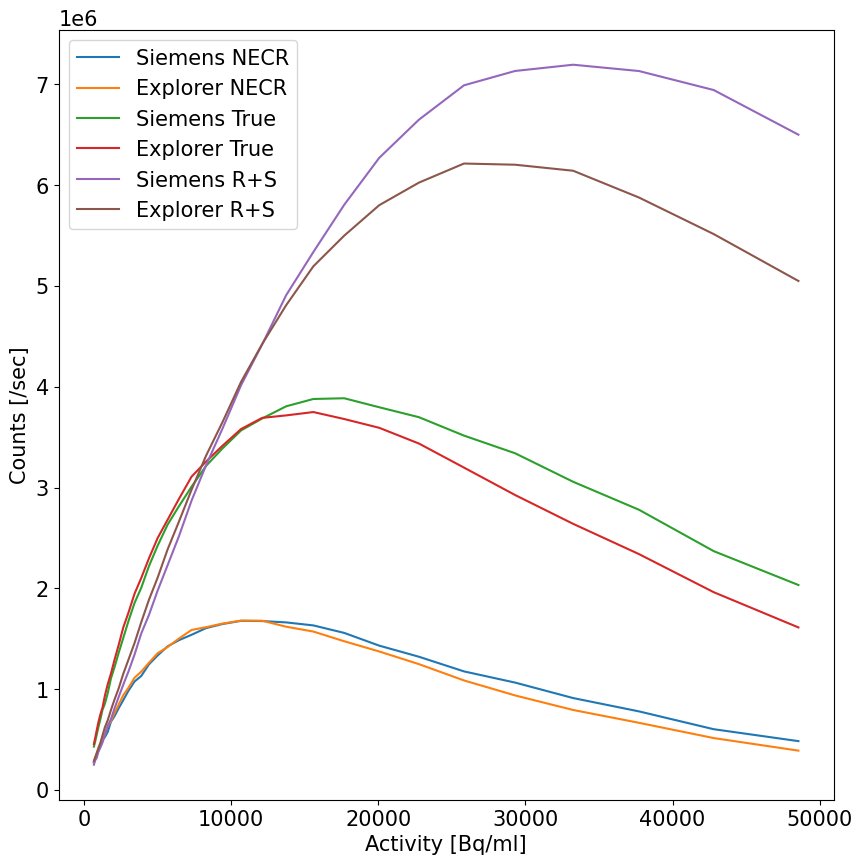

In [3]:
labels = [ "Siemens NECR", "Explorer NECR", "Siemens True", "Explorer True", "Siemens R+S", "Explorer R+S" ]
mpl.plot( activityAtTimeSiemens, necrAtTimeSiemens, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrAtTimeExplorer, label=labels[1] )
mpl.plot( activityAtTimeSiemens, trueAtTimeSiemens, label=labels[2] )
mpl.plot( activityAtTimeExplorer, trueAtTimeExplorer, label=labels[3] )
mpl.plot( activityAtTimeSiemens, rPlusSAtTimeSiemens, label=labels[4] )
mpl.plot( activityAtTimeExplorer, rPlusSAtTimeExplorer, label=labels[5] )
mpl.legend( labels )
mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
mpl.gcf().set_size_inches(10, 10)
mpl.show()

Calculate an error envolope by including the resolution effects in pseudoexperiments

Re-run the experiment 5 times at each working point, with the resolution applying a gaussian-distributed offset to each photon's energy and detection time. Uses multiprocessing.

Results are plotted as a range from highest to lowest value at each working point, with the nominal value being the mean.

In [4]:
import multiprocessing as mp
mp.set_start_method('fork')
from multiprocessing import Pool
import numpy as np

def CreateErrorEnvelope( tracerData, crystalData, crystalActivity, detectorRadius,
                         phantomLength, simulationWindow=1E-2, coincidenceWindow=4.7E-9, processes=10,
                         EnergyResolution=0.0, TimeResolution=0.0 ):
    
    # Create the arguments for each process
    arguments = []
    for experiment in range(10):
        arguments.append( ( tracerData, crystalData, crystalActivity, detectorRadius,
                            phantomLength, simulationWindow, coincidenceWindow,
                            EnergyResolution, TimeResolution ) )
    
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( NECRatTimeF18, arguments )
    
    # Unpack the results
    necrEnvelope = []
    trueEnvelope = []
    rPlusSEnvelope = []
    scatterEnvelope = []
    randomEnvelope = []
    for entry in result:
        necrEnvelope.append( entry[1] )
        trueEnvelope.append( entry[2] )
        rPlusSEnvelope.append( entry[3] )
        scatterEnvelope.append( entry[4] )
        randomEnvelope.append( entry[5] )
    return result[0][0], np.transpose( necrEnvelope ), np.transpose( np.array(trueEnvelope) ), np.transpose( np.array(rPlusSEnvelope) ), np.transpose( np.array(scatterEnvelope) ), np.transpose( np.array(randomEnvelope) )

detectorMaterial = "LSO"
activityAtTimeSiemens, necrEnvelopeSiemens, trueEnvelopeSiemens, rPlusSEnvelopeSiemens, scatterEnvelopeSiemens, randomEnvelopeSiemens = CreateErrorEnvelope(
    tracerDataSiemens, crystalDataSiemens, sqp.Lu176decaysInMass( sqp.DetectorMass( detectorMaterial ) ),
    sqp.DetectorRadius(), phantomLength, EnergyResolution=0.1, TimeResolution=0.5 )

detectorMaterial = "LYSO"
activityAtTimeExplorer, necrEnvelopeExplorer, trueEnvelopeExplorer, rPlusSEnvelopeExplorer, scatterEnvelopeExplorer, randomEnvelopeExplorer = CreateErrorEnvelope(
    tracerDataExplorer, crystalDataExplorer, ep.Lu176decaysInMass( ep.DetectorMass( detectorMaterial ) ),
    ep.DetectorRadius(), phantomLength, EnergyResolution=0.1, TimeResolution=0.5 )

In [5]:
def GetMinMaxFromEnvelope( envelope ):
    
    allMax = []
    allMin = []
    allMean = []
    for entry in envelope:
        # Basic
        #allMax.append( max(entry) )
        #allMin.append( min(entry) )
        #allMean.append( np.mean(entry) )
        
        nominal = np.mean(entry)
        sysUp = max(entry) - nominal
        sysDown = nominal - min(entry)
        combinedUp = math.sqrt( (sysUp**2) + nominal ) # stat err is sqrt(nominal)
        combinedDown = math.sqrt( (sysDown**2) + nominal )
        #print( "Errors: ", sysUp*100/nominal, sysDown*100/nominal, 100/math.sqrt(nominal))
        allMax.append( nominal + combinedUp )
        allMin.append( nominal - combinedDown )
        allMean.append( nominal )

    return allMin, allMax, allMean

necrMinSiemens, necrMaxSiemens, necrMeanSiemens = GetMinMaxFromEnvelope( necrEnvelopeSiemens )
trueMinSiemens, trueMaxSiemens, trueMeanSiemens = GetMinMaxFromEnvelope( trueEnvelopeSiemens )
rPlusSMinSiemens, rPlusSMaxSiemens, rPlusSMeanSiemens = GetMinMaxFromEnvelope( rPlusSEnvelopeSiemens )
scatterMinSiemens, scatterMaxSiemens, scatterMeanSiemens = GetMinMaxFromEnvelope( scatterEnvelopeSiemens )
randomMinSiemens, randomMaxSiemens, randomMeanSiemens = GetMinMaxFromEnvelope( randomEnvelopeSiemens )

necrMinExplorer, necrMaxExplorer, necrMeanExplorer = GetMinMaxFromEnvelope( necrEnvelopeExplorer )
trueMinExplorer, trueMaxExplorer, trueMeanExplorer = GetMinMaxFromEnvelope( trueEnvelopeExplorer )
rPlusSMinExplorer, rPlusSMaxExplorer, rPlusSMeanExplorer = GetMinMaxFromEnvelope( rPlusSEnvelopeExplorer )
scatterMinExplorer, scatterMaxExplorer, scatterMeanExplorer = GetMinMaxFromEnvelope( scatterEnvelopeExplorer )
randomMinExplorer, randomMaxExplorer, randomMeanExplorer = GetMinMaxFromEnvelope( randomEnvelopeExplorer )

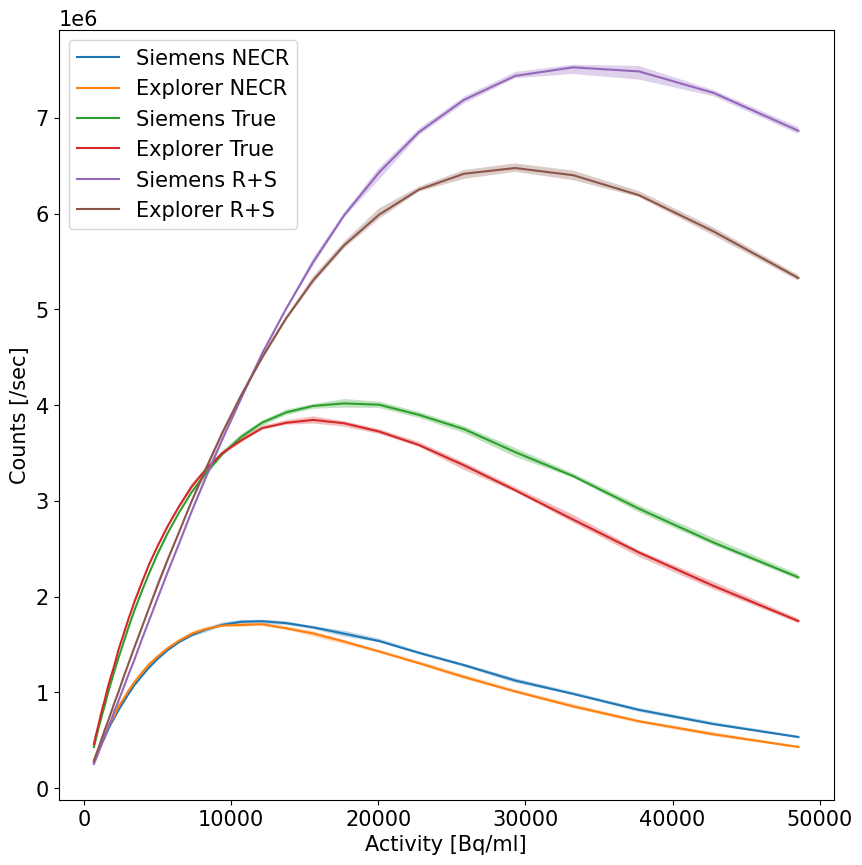

In [6]:
labels = [ "Siemens NECR", "Explorer NECR", "Siemens True", "Explorer True", "Siemens R+S", "Explorer R+S" ]
mpl.plot( activityAtTimeSiemens, necrMeanSiemens, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrMeanExplorer, label=labels[1] )
mpl.plot( activityAtTimeSiemens, trueMeanSiemens, label=labels[2] )
mpl.plot( activityAtTimeExplorer, trueMeanExplorer, label=labels[3] )
mpl.plot( activityAtTimeSiemens, rPlusSMeanSiemens, label=labels[4] )
mpl.plot( activityAtTimeExplorer, rPlusSMeanExplorer, label=labels[5] )
mpl.legend( labels )

mpl.fill_between( activityAtTimeSiemens, necrMinSiemens, necrMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, necrMinExplorer, necrMaxExplorer, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, trueMinSiemens, trueMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, trueMinExplorer, trueMaxExplorer, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, rPlusSMinSiemens, rPlusSMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, rPlusSMinExplorer, rPlusSMaxExplorer, alpha=0.3 )

mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
# mpl.xlim([0, 25000])
mpl.gcf().set_size_inches(10, 10)
mpl.show()

Counts vs. activity concentration plots with Siemens Quadra and Explorer count rates separately

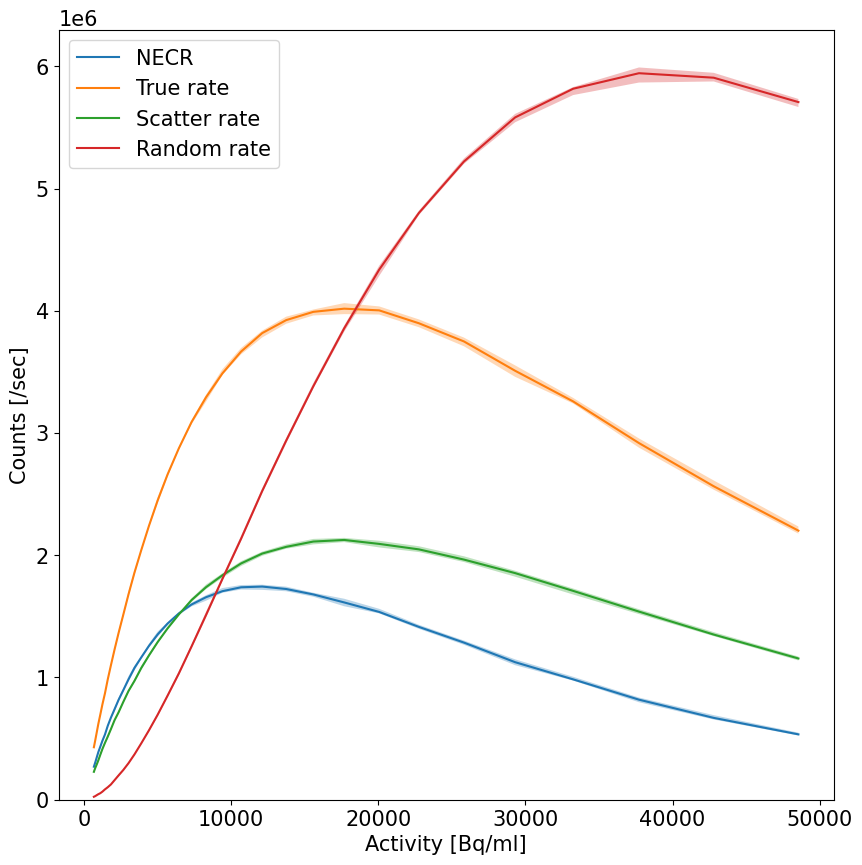

In [7]:
labels = [ "NECR", "True rate", "Scatter rate", "Random rate"]
mpl.plot( activityAtTimeSiemens, necrMeanSiemens, label=labels[0] )
mpl.plot( activityAtTimeSiemens, trueMeanSiemens, label=labels[1] )
mpl.plot( activityAtTimeSiemens, scatterMeanSiemens, label=labels[2] )
mpl.plot( activityAtTimeSiemens, randomMeanSiemens, label=labels[3] )
mpl.legend( labels )

mpl.fill_between( activityAtTimeSiemens, necrMinSiemens, necrMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, trueMinSiemens, trueMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, scatterMinSiemens, scatterMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, randomMinSiemens, randomMaxSiemens, alpha=0.3 )

mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
mpl.ylim([0, 6.3E6])
mpl.gcf().set_size_inches(10, 10)
# mpl.show()
mpl.savefig("siemens_counts.png")

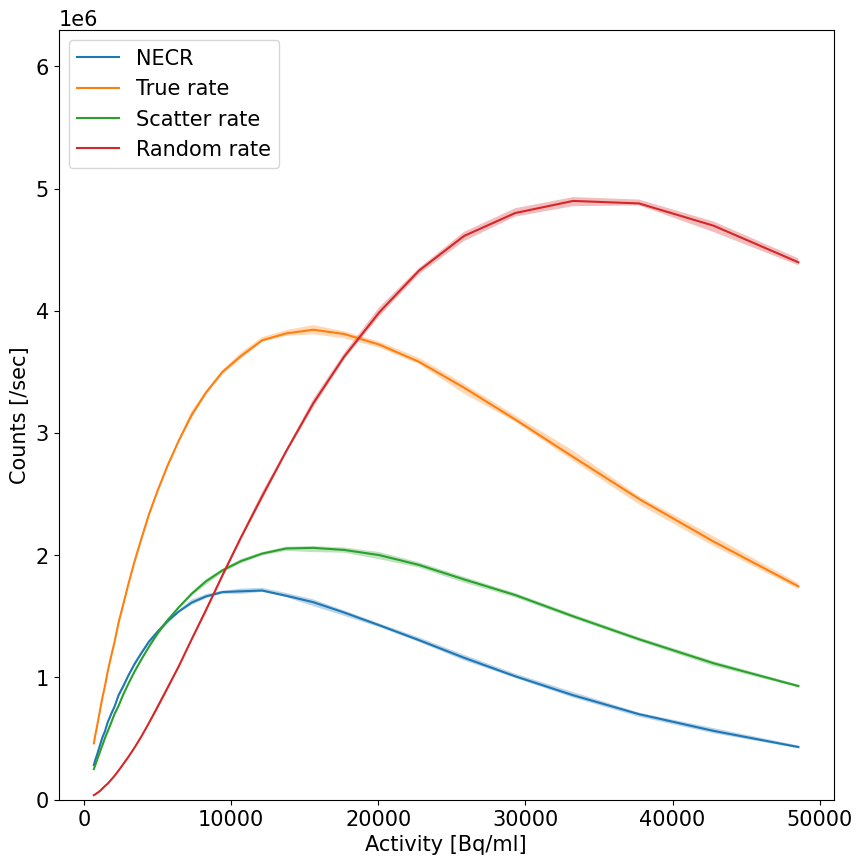

In [8]:
labels = [ "NECR", "True rate", "Scatter rate", "Random rate"]
mpl.plot( activityAtTimeExplorer, necrMeanExplorer, label=labels[0] )
mpl.plot( activityAtTimeExplorer, trueMeanExplorer, label=labels[1] )
mpl.plot( activityAtTimeExplorer, scatterMeanExplorer, label=labels[2] )
mpl.plot( activityAtTimeExplorer, randomMeanExplorer, label=labels[3] )
mpl.legend( labels )

mpl.fill_between( activityAtTimeExplorer, necrMinExplorer, necrMaxExplorer, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, trueMinExplorer, trueMaxExplorer, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, scatterMinExplorer, scatterMaxExplorer, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, randomMinExplorer, randomMaxExplorer, alpha=0.3 )

mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
mpl.ylim([0, 6.3E6])
mpl.gcf().set_size_inches(10, 10)
# mpl.show()
mpl.savefig("explorer_counts.png")

Compare detectors for a 1.5m patient, assuming head-to-toe scan

In [9]:
phantomLength = 1500

detectorMaterial = "LSO"
tracerDataSiemens15 = CreateDataset( 1024, "Siemens", phantomLength, "LinearF18", datasetSize, siemensEmin, siemensEmax, detectorMaterial )
crystalDataSiemens15 = CreateDataset( 1024, "Siemens", phantomLength, "Siemens", datasetSize, siemensEmin, siemensEmax, detectorMaterial )

activityAtTimeSiemens, necrEnvelopeSiemens15, trueEnvelopeSiemens15, rPlusSEnvelopeSiemens15, scatterEnvelopeSiemens15, randomEnvelopeSiemens15 = CreateErrorEnvelope(
    tracerDataSiemens15, crystalDataSiemens15, sqp.Lu176decaysInMass( sqp.DetectorMass( detectorMaterial ) ),
    sqp.DetectorRadius(), phantomLength, EnergyResolution=0.1, TimeResolution=0.5 )

detectorMaterial = "LYSO"
tracerDataExplorer15 = CreateDataset( 1850, "Explorer", phantomLength, "LinearF18", datasetSize, explorerEmin, explorerEmax, detectorMaterial )
crystalDataExplorer15 = CreateDataset( 1850, "Explorer", phantomLength, "Explorer", datasetSize, explorerEmin, explorerEmax, detectorMaterial )

activityAtTimeExplorer, necrEnvelopeExplorer15, trueEnvelopeExplorer15, rPlusSEnvelopeExplorer15, scatterEnvelopeExplorer15, randomEnvelopeExplorer15 = CreateErrorEnvelope(
    tracerDataExplorer15, crystalDataExplorer15, ep.Lu176decaysInMass( ep.DetectorMass( detectorMaterial ) ),
    ep.DetectorRadius(), phantomLength, EnergyResolution=0.1, TimeResolution=0.5 )

Re-using previous simulation
150207.0 events loaded (1000000 simulated) with average 1.1003615011284427 hits/event
command =  ../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1024 --source Siemens --phantomLengthMM 1500 --outputFileName hits.n1000000.SiemensBlock.1024mm.Siemens.1500mm.1234.csv --randomSeed 1234 --detectorMaterial LSO

**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: Lu2SiO5
Siemens Quadra detector w

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron internal conversion 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron internal conversion 

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.


### ===  Auger cascade flag: 1
### ===  Ignore cuts flag:   1

phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 k


msc:  for pi+  SubType= 10
      RangeFactor= 0.2, stepLimType: 0, latDisp: 0
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
        WentzelVIUni : Emin=    0 eV  Emax=  100 TeV Nbins=84 100 eV  - 100 TeV

hIoni:  for pi+  SubType=2
      dE/dx and range tables from 100 eV  to 100 TeV in 84 bins
      Lambda tables from threshold to 100 TeV, 7 bins/decade, spline: 1
      StepFunction=(0.2, 0.1 mm), integ: 1, fluct: 1, linLossLim= 0.01
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
               Bragg : Emin=    0 eV  Emax=297.505 keV
          BetheBloch : Emin=297.505 keV Emax=  100 TeV

hBrems:  for pi+  SubType=3
      dE/dx and range tables from 100 eV  to 100 TeV in 84 bins
      Lambda tables from threshold to 100 TeV, 7 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
               hBrem : Emin=    0 eV  Emax=  100 TeV

hPairProd:  for pi+  SubType=4
      dE/dx and range tables f

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron internal conversion 

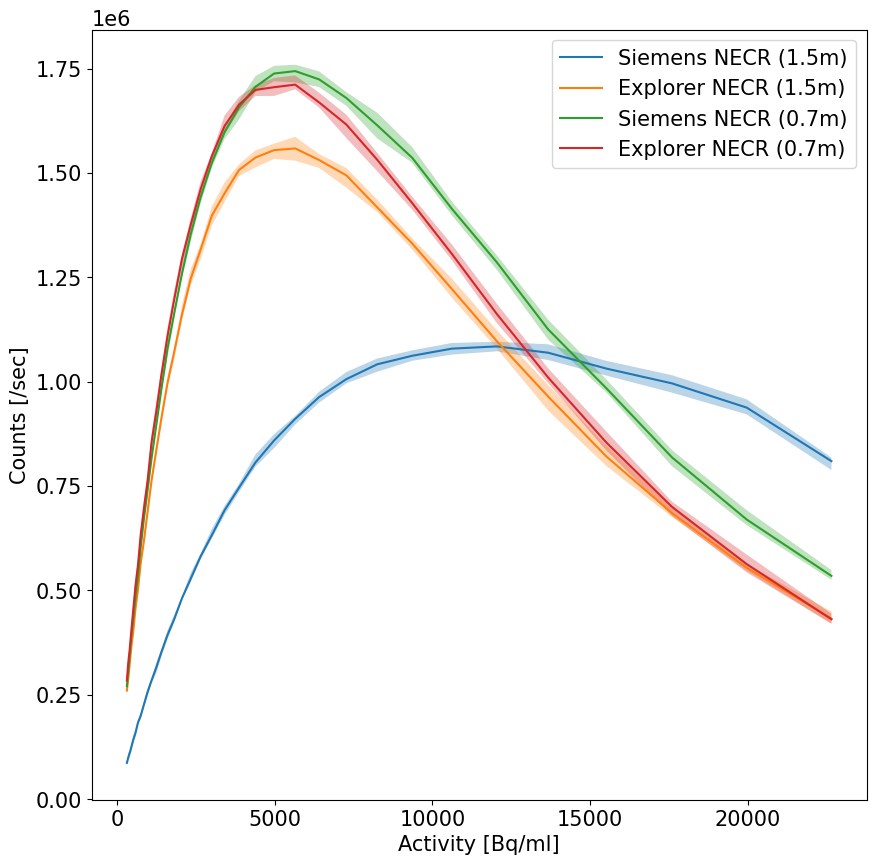

In [10]:
necrMinSiemens15, necrMaxSiemens15, necrMeanSiemens15 = GetMinMaxFromEnvelope( necrEnvelopeSiemens15 )
necrMinExplorer15, necrMaxExplorer15, necrMeanExplorer15 = GetMinMaxFromEnvelope( necrEnvelopeExplorer15 )

labels = [ "Siemens NECR (1.5m)", "Explorer NECR (1.5m)", "Siemens NECR (0.7m)", "Explorer NECR (0.7m)" ]
mpl.plot( activityAtTimeSiemens, necrMeanSiemens15, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrMeanExplorer15, label=labels[1] )
mpl.plot( activityAtTimeSiemens, necrMeanSiemens, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrMeanExplorer, label=labels[1] )
mpl.legend( labels, loc="upper right" )

mpl.fill_between( activityAtTimeSiemens, necrMinSiemens15, necrMaxSiemens15, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, necrMinExplorer15, necrMaxExplorer15, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, necrMinSiemens, necrMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, necrMinExplorer, necrMaxExplorer, alpha=0.3 )

mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
mpl.gcf().set_size_inches(10, 10)
mpl.savefig( "test.png" )
mpl.show()